# Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import statsmodels.api as sm


In [156]:
df = pd.read_csv("/Users/roraimachavez/Downloads/7.IRONHACK/Labs/FifthWeek/lab-eda-univariate/amz_uk_price_prediction_dataset.csv")

### Part 1: Analyzing Best-Seller Trends Across Product Categories

Objective: Understand the relationship between product categories and their best-seller status.

In [157]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


1. Crosstab Analysis:

`Create a crosstab between the product category and the isBestSeller status.`

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

In [158]:
# Cruce entre columnas
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

# Se agrega una columna extra a la variable anterior con el resultado de los calculos. 
crosstab_result['proportion_best_seller'] = crosstab_result[True] / crosstab_result.sum(axis=1)

# Ordenar las categorías en función de la proporción en orden descendente
crosstab_sorted = crosstab_result.sort_values(by='proportion_best_seller', ascending=False)


In [159]:
crosstab_result.head()

isBestSeller,False,True,proportion_best_seller
category,,,
3D Printers,247,1,0.004032
3D Printing & Scanning,4065,2,0.000492
Abrasive & Finishing Products,245,5,0.020000
Action Cameras,1696,1,0.000589
Adapters,251,3,0.011811


In [160]:
crosstab_sorted

isBestSeller,False,True,proportion_best_seller
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


`Are there categories where being a best-seller is more prevalent?`

Si, categorias como gocery, Smart Home Security & Lighting, Health & Personal Care, etc., son mas probables que salgan como best-seller.	 


2. Statistical Tests:

`Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.`

In [161]:
# Chi-square test for 'isBestSeller' and 'category'
_, chi2_p_value, _, _ = chi2_contingency(crosstab_sorted)

chi2_p_value

0.0

In [162]:
chi2_p_value < 0.5 # Sufficient evidence to conclude there is a relationship between variables.

True

`Compute Cramér's V to understand the strength of association between best-seller status and category.`


In [163]:
crosstab_result_ok = pd.crosstab(df['category'], df['isBestSeller'])

In [164]:
crosstab_result_ok

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


3. Visualizations:

`Visualize the relationship between product categories and the best-seller status using a stacked bar chart.`

In [165]:
association(crosstab_result_ok, method="cramer")

0.1222829439760564

<Axes: xlabel='category'>

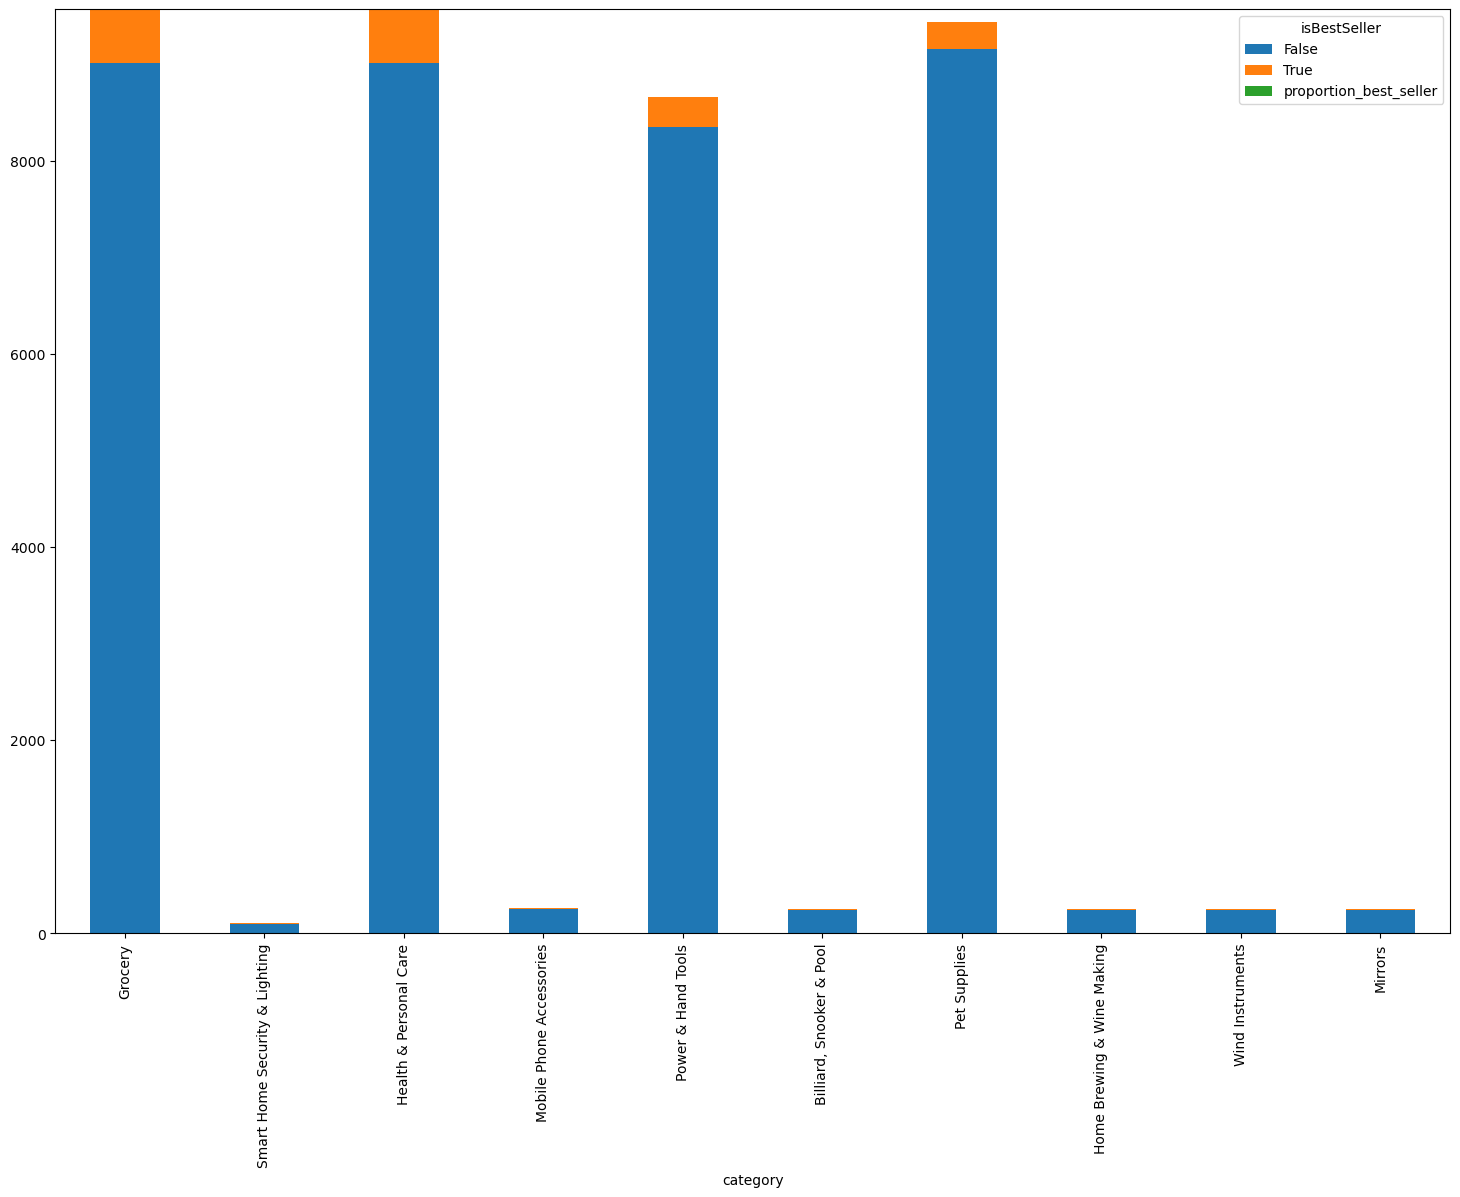

In [166]:
# Visualize the relationship between product categories and the best-seller status using a stacked bar chart.
crosstab_sorted = crosstab_sorted.head(10)
crosstab_sorted.plot(kind="bar", stacked=True, figsize=(18,12))

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

Objective: Investigate how different product categories influence product prices.

In [167]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


`1. Preliminary Step: Remove outliers in product prices.`

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.


In [168]:
data = df["price"]

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
    
# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
# Identify the outliers
df_filter =df[(data >= lower_bound) | (data <= upper_bound)]

In [169]:
df_filter

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


`2. Violin Plots:`

- Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.

In [170]:
top_categories = df_filter['category'].value_counts().nlargest(20).index

In [171]:
df_distribution = df_filter[df_filter['category'].isin(top_categories)]

<Axes: xlabel='category', ylabel='price'>

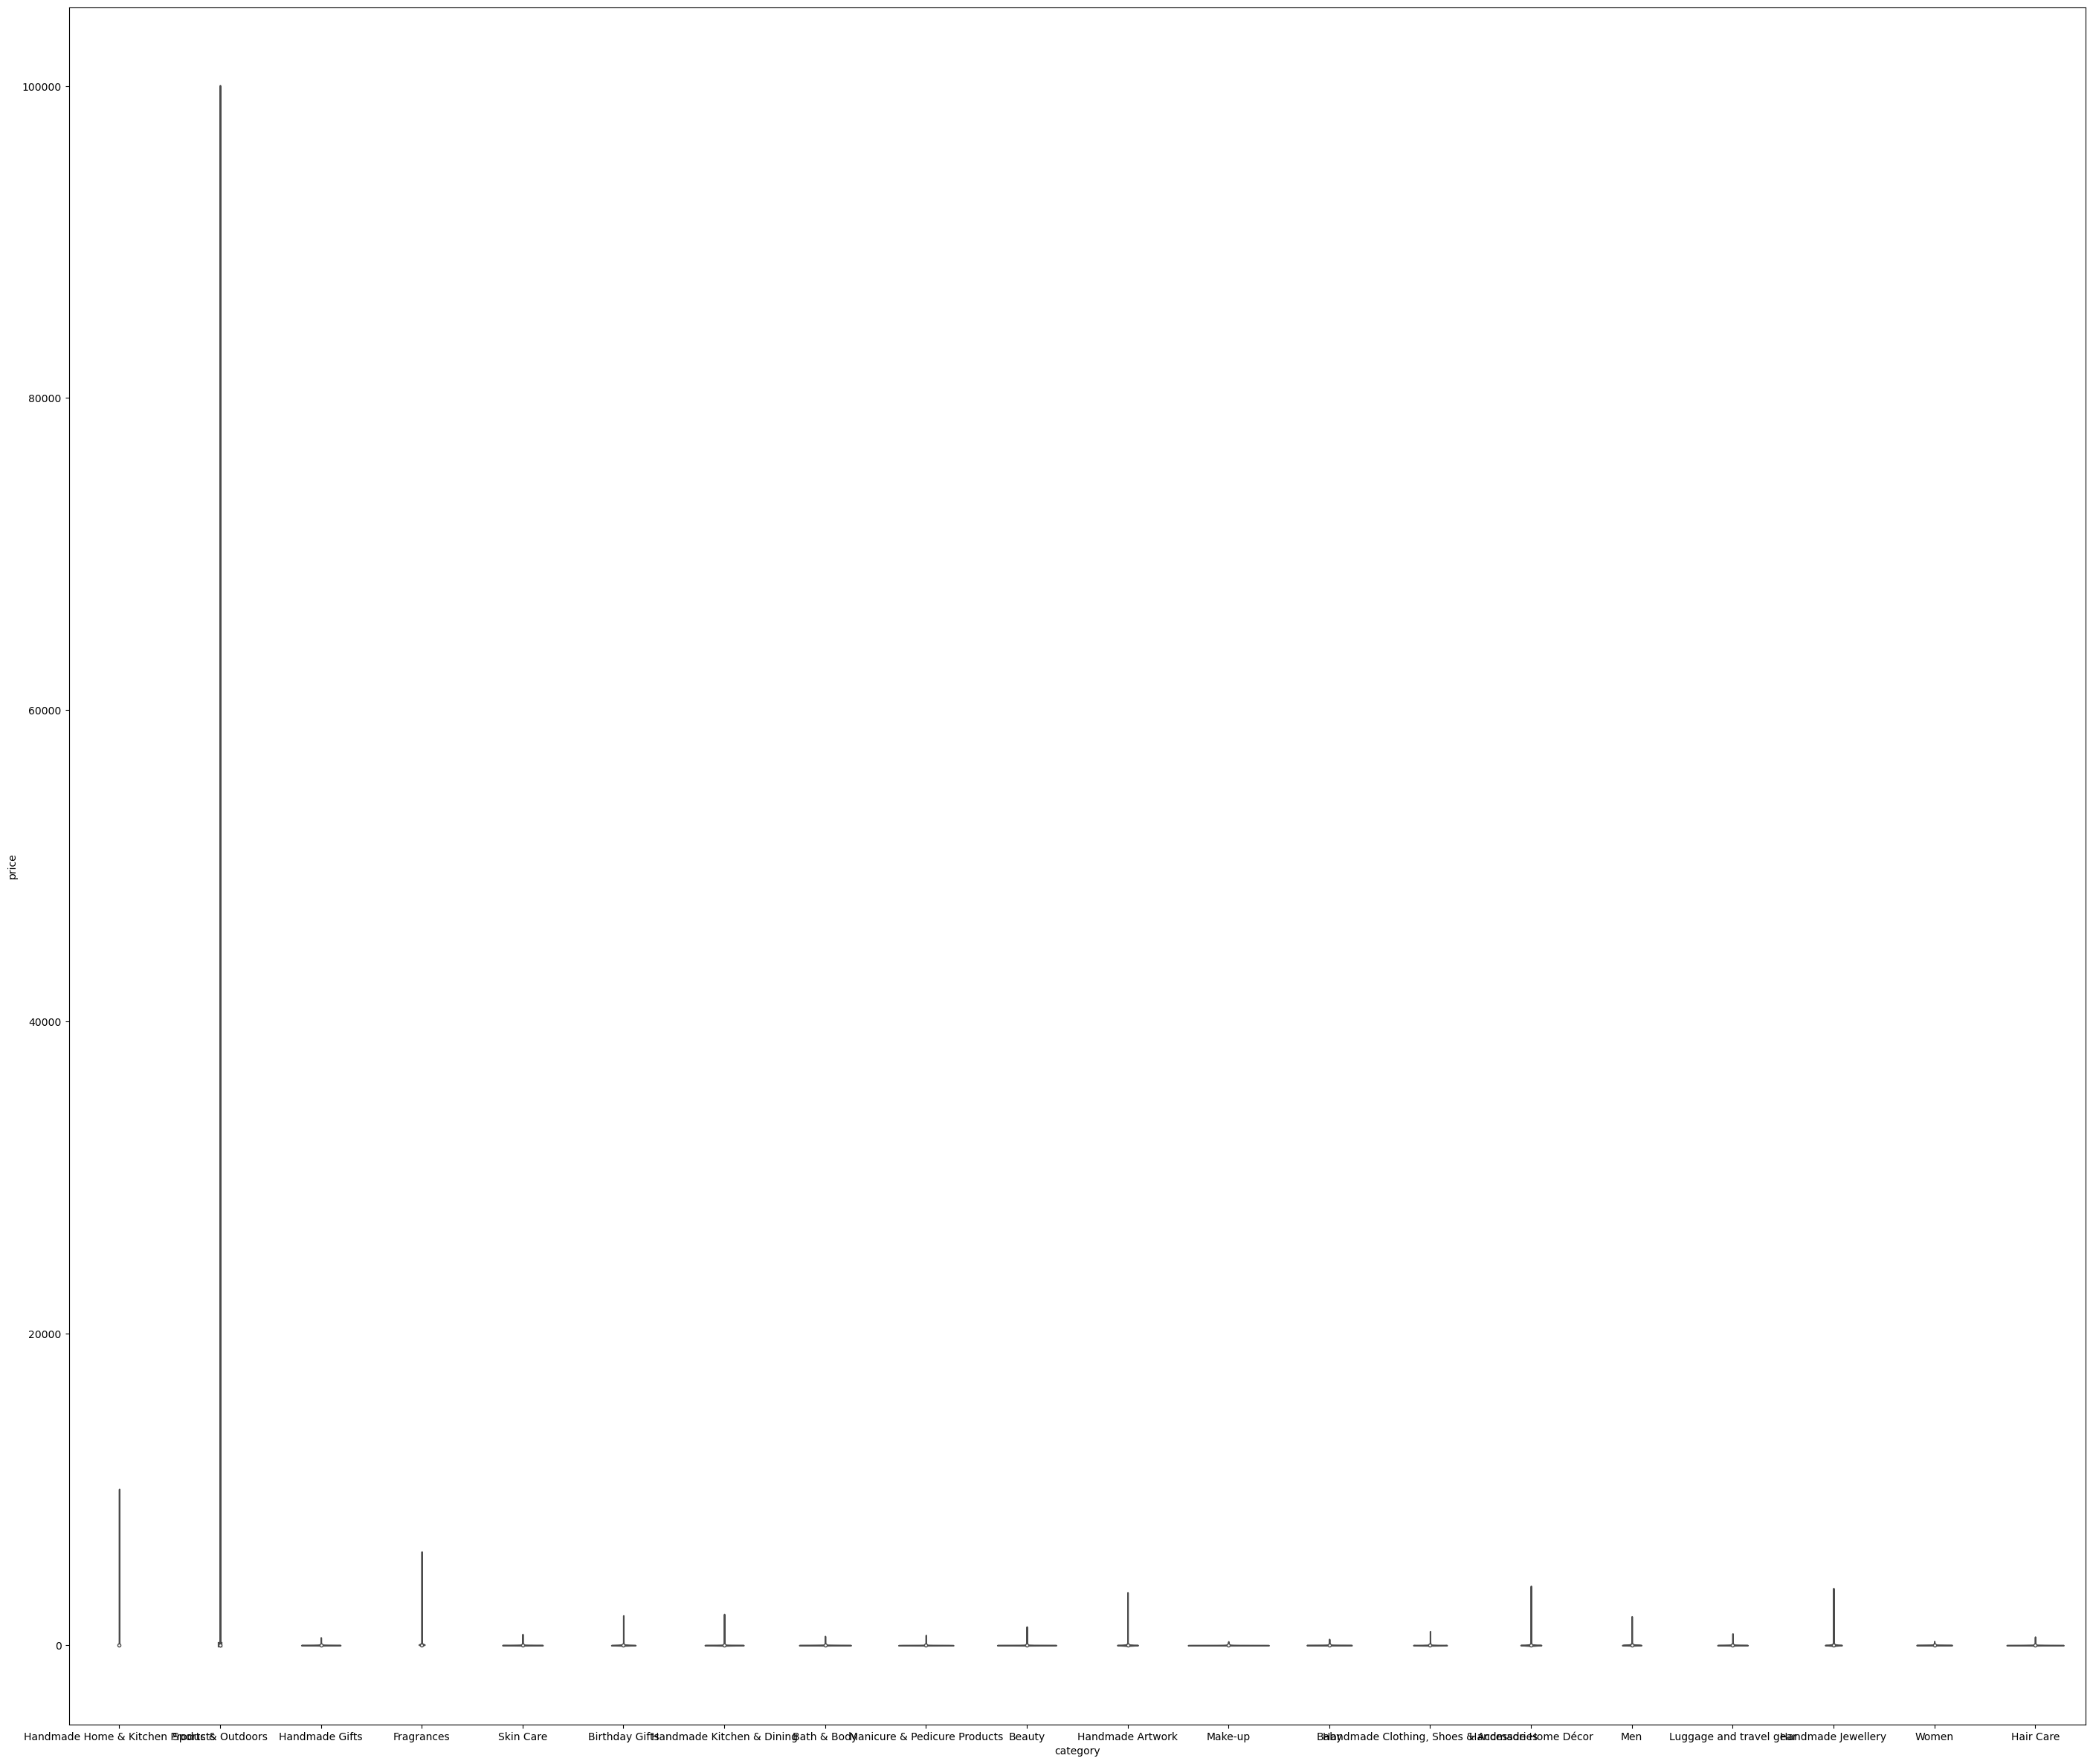

In [172]:
plt.figure(figsize=(35, 30))
sns.violinplot(data=df_distribution, x="category", y='price', palette="coolwarm")

- Which product category tends to have the highest median price? Don't filter here by top categories.


In [173]:
highest_median_price_category = df.groupby('category')['price'].median().idxmax()
print("The category with the highest median price is:", highest_median_price_category) 

The category with the highest median price is: Laptops


`3. Bar Charts:`

- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

In [174]:
average_prices_category = df_distribution.groupby('category')['price'].mean()

In [175]:
top_10_categories = df_filter['category'].value_counts().nlargest(10).index

In [176]:
avg_price_category = average_prices_category.loc[top_10_categories]

In [177]:
avg_price_category

category
Sports & Outdoors                         125.769814
Beauty                                     13.222322
Handmade Clothing, Shoes & Accessories     16.865767
Bath & Body                                15.042266
Birthday Gifts                             26.585166
Manicure & Pedicure Products               10.521108
Skin Care                                  16.340926
Make-up                                    10.895356
Hair Care                                  14.326030
Fragrances                                 36.202865
Name: price, dtype: float64

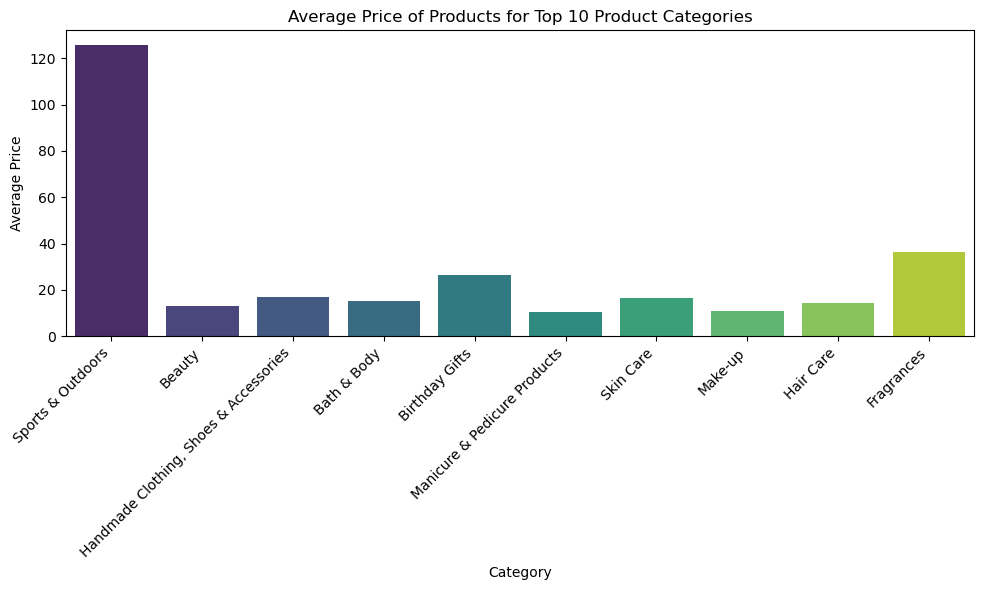

In [178]:
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_category.index, y=avg_price_category.values, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.title('Average Price of Products for Top 10 Product Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Which product category commands the highest average price? Don't filter here by top categories.


In [179]:
highest_avg_price_category = df.groupby('category')['price'].mean().idxmax()
print("The category with the highest average price is:", highest_avg_price_category)

The category with the highest average price is: Laptops


4. Box Plots:

`Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.`                                                                            

In [180]:
top_10_categories = df_filter['category'].value_counts().nlargest(10).index
df_distribution = df_filter[df_filter['category'].isin(top_10_categories)]

<Axes: xlabel='category', ylabel='stars'>

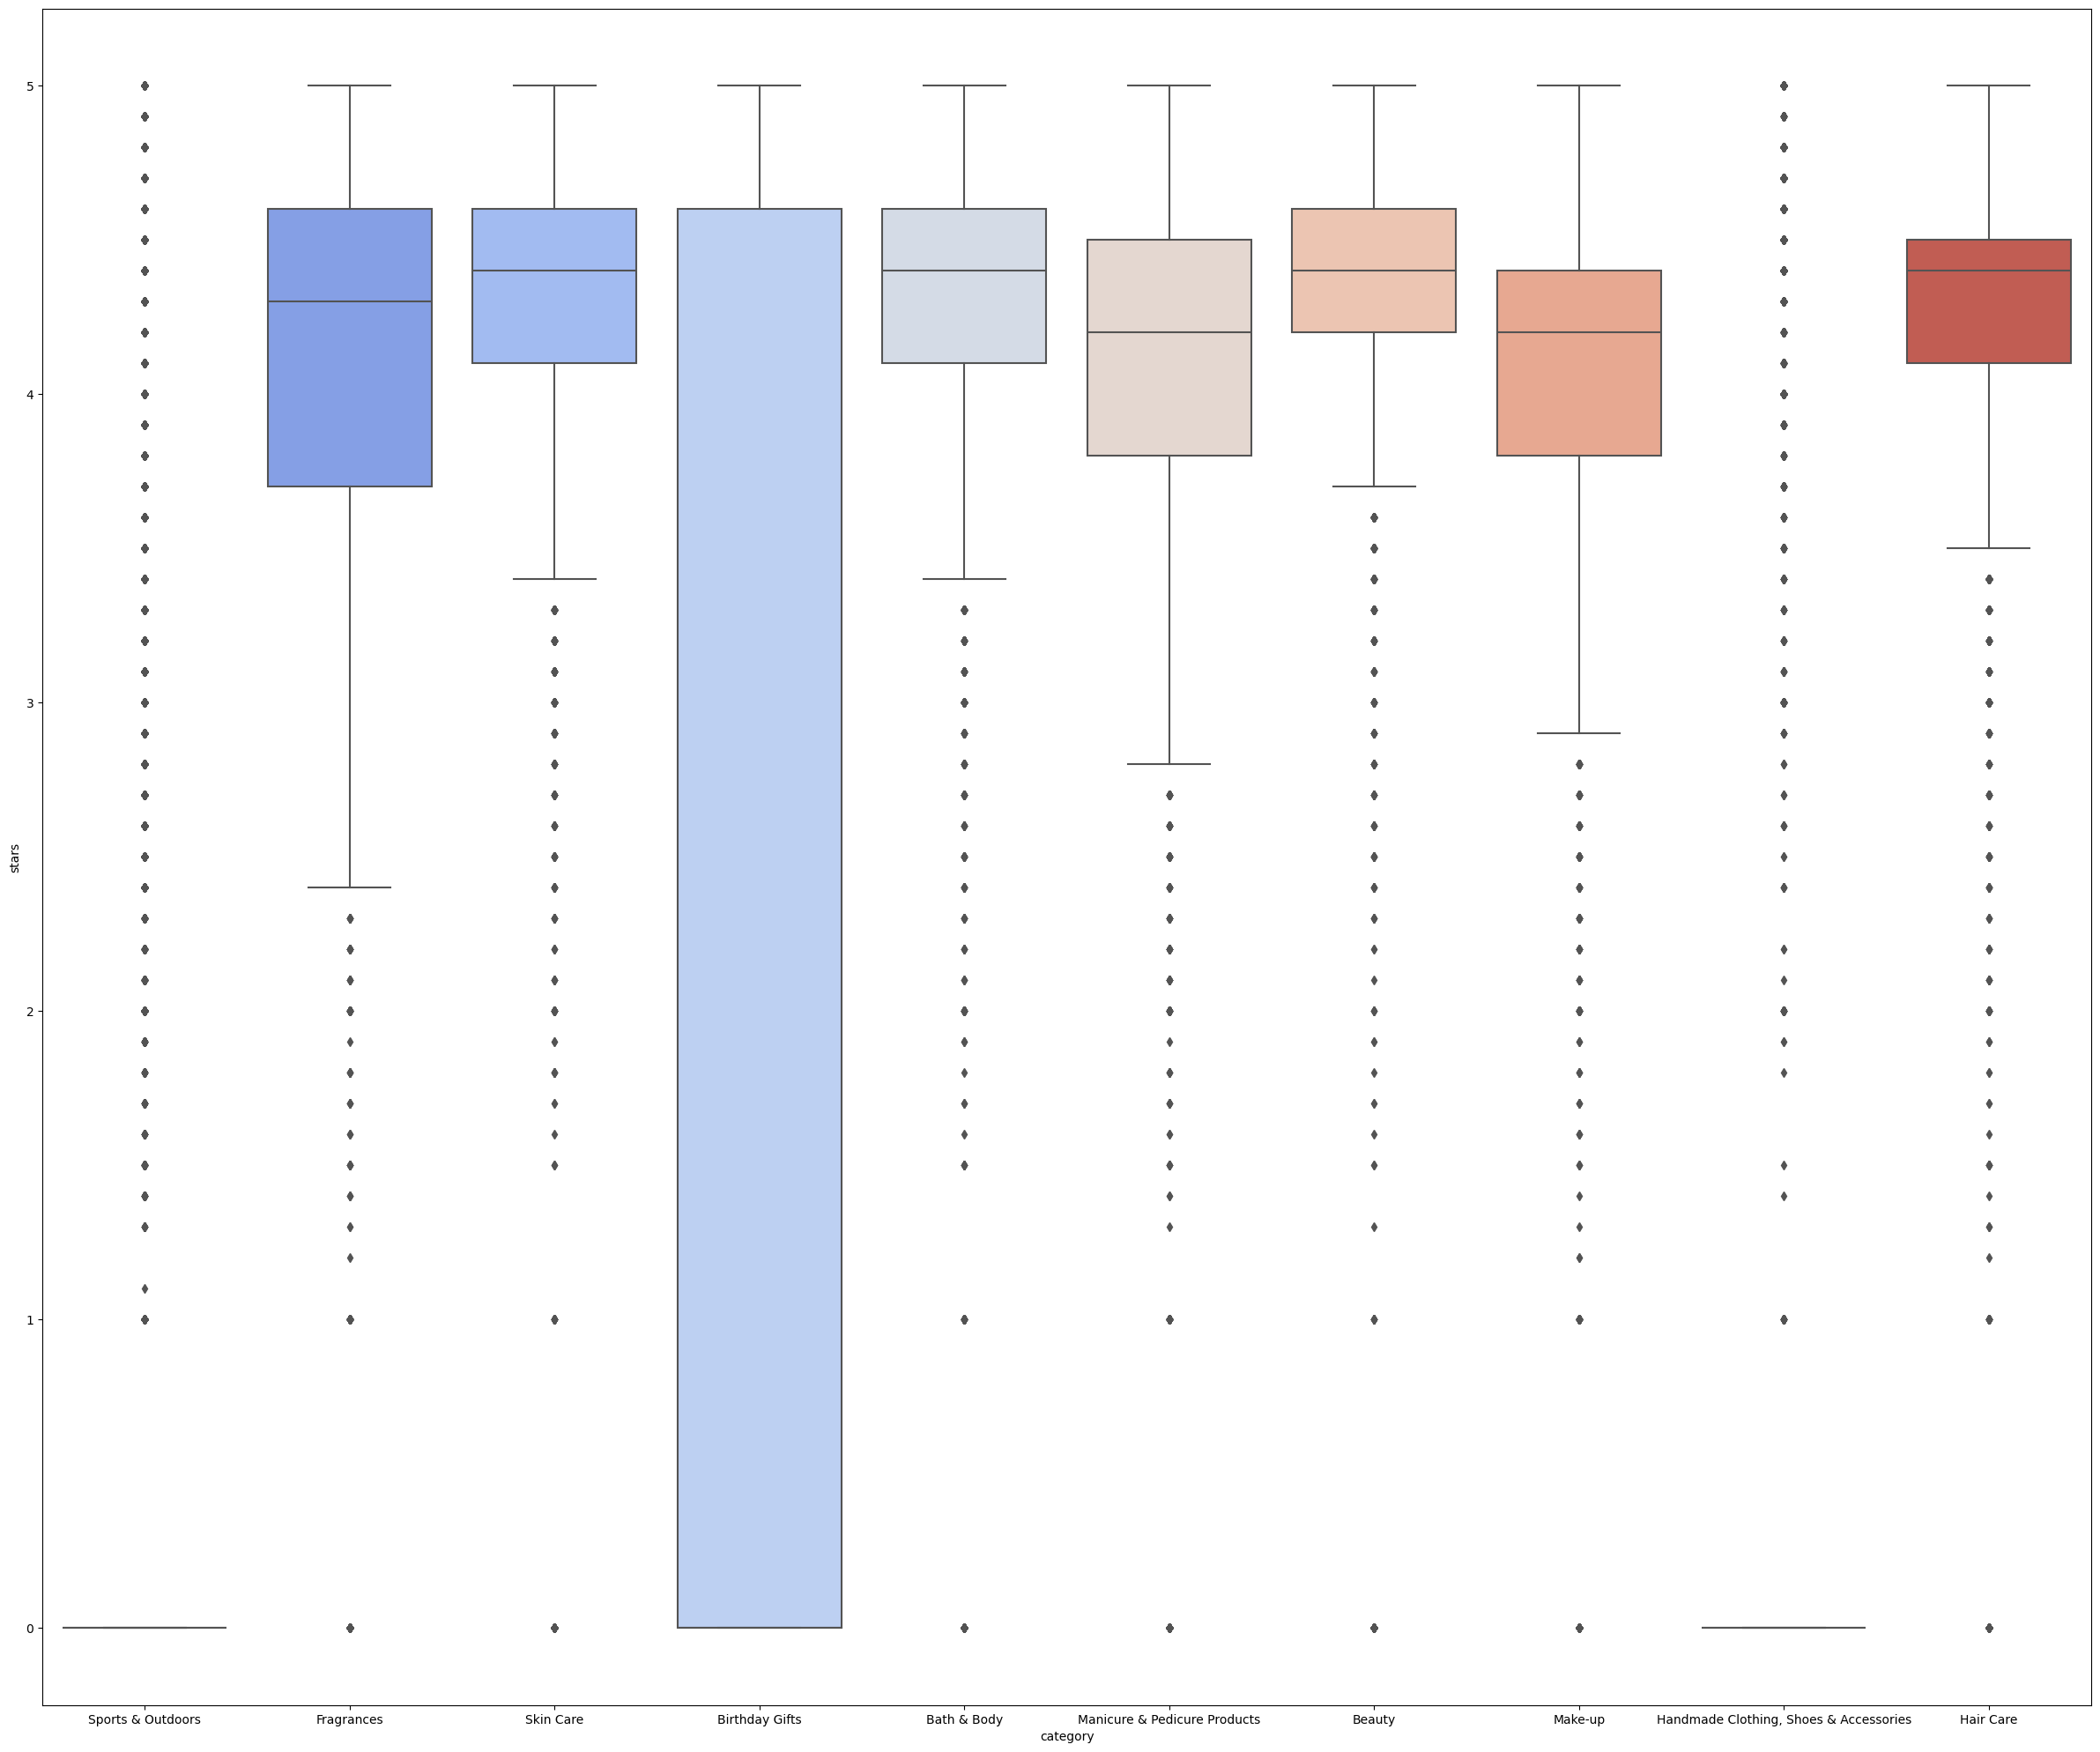

In [181]:
plt.figure(figsize=(30, 25))
sns.boxplot(data=df_distribution, x='category', y='stars', palette="coolwarm")

`Which category tends to receive the highest median rating from customers? Don't filter here by top categories.`

In [182]:
highest_median_stars_category = df.groupby('category')['stars'].median().idxmax()
print("The category with the highest median stars is:", highest_median_stars_category) 

The category with the highest median stars is: Computer Memory


### Part 3: Investigating the Interplay Between Product Prices and Ratings

Objective: Analyze how product ratings (stars) correlate with product prices.

In [183]:
df_filter.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


1. Correlation Coefficients:

`Calculate the correlation coefficient between price and stars.`

In [184]:
correlation = df_filter['stars'].corr(df_filter['price'])
correlation

-0.12490673262148688

`Is there a significant correlation between product price and its rating?`

Yes, because closer to −1 means a stronger relationship.

Negative values: As one variable increases, the other tends to decrease.


2. Visualizations:

`Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?`

<Axes: xlabel='stars', ylabel='price'>

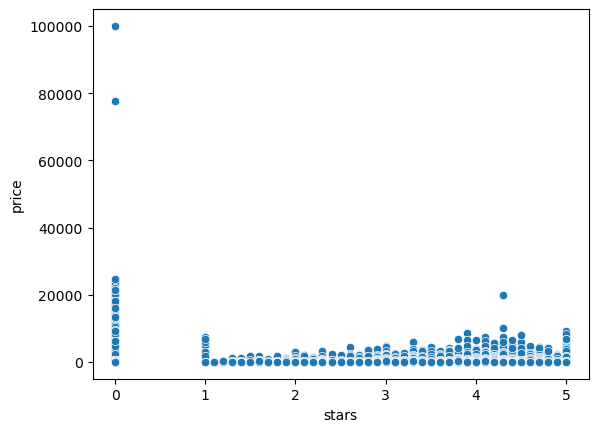

In [185]:
sns.scatterplot(data=df_filter, x='stars', y='price')

**What patterns can you observe?**

- Que nadie vota entre 0 y 1.
- Que las votaciones "reales" comienzan a partir del 2.

`Use a correlation heatmap to visualize correlations between all numerical variables.`

In [186]:
numeric_df = df_filter.select_dtypes(include='number')

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

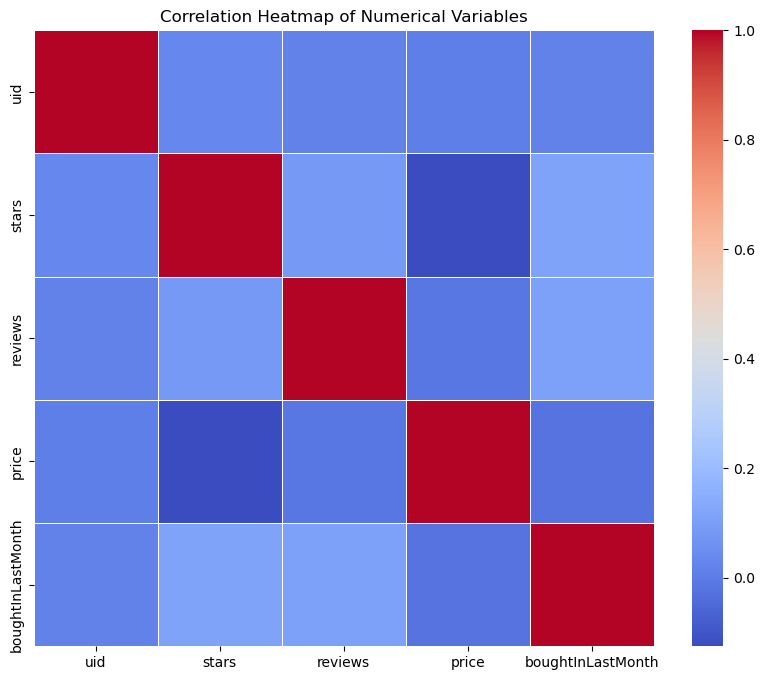

In [187]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

`Examine if product prices typically follow a normal distribution using a QQ plot.`

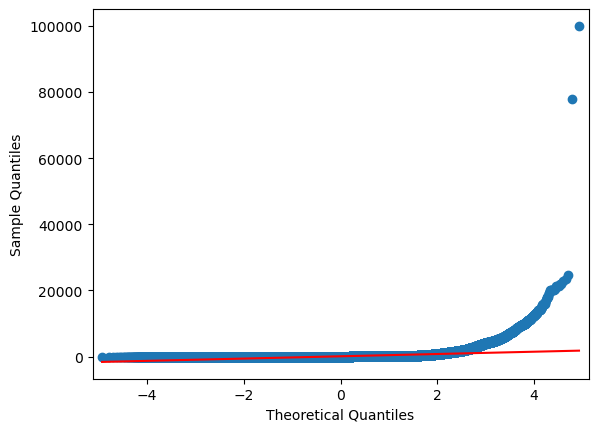

In [188]:
sm.qqplot(df['price'], line='s');